In [1]:
import numpy as np
import scipy as sp
import sympy as sm
from scipy import linalg
from scipy import optimize
from scipy import interpolate

%matplotlib inline
import matplotlib.pyplot as plt # baseline modul
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
plt.style.use('seaborn-whitegrid') # whitegrid nice with 3d

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [3]:
N = 10000
np.random.seed(2020)
x1,x2,y = DGP(N)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}

## answer to question 1.1:

In [4]:
#creating an array to turn into X
X = np.arange(N*3).reshape(N,3) # 10,000 lists 3 objects in each list.
X = X.astype(np.float32) # converting to floats.

In [5]:
# assigning the values 1, x1, and x2 to element 0, 1, and 2 in each list of the array.
for i in range(N):
    X[i][0] = 1
    X[i][1] = x1[i]
    X[i][2] = x2[i]

# creating an array containing 1 list of y values.
y = np.array(y)

# generating variable for transposed X
XT = X.T

# generating the inverse of XT times X
# first XT times X
XTX = XT@X
# then inverse it
XTXI = linalg.inv(XTX)

In [6]:
# checking everything looks correct
print('X02', X[0][2])
print('X', X[0:2])
print('y', y)
print('XT', XT)
print('XTX', XTX, XTX.shape) #must be a 3x3 matrix
print('XTXI', XTXI, XTXI.shape) # also a 3x3 matrix
print('Inverse times normal', XTXI@XTX) # might not be equal to identity matrix, but that's just how it is working with floats.

X02 -0.18279442
X [[ 1.         -1.7688457  -0.18279442]
 [ 1.          0.07555227  0.7806237 ]]
y [-1.06458366  0.58562919 -0.91755295 ... -6.98529298  0.08526139
  0.70458339]
XT [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-1.7688457   0.07555227 -1.1306297  ...  0.0370484   1.7089268
   2.0612805 ]
 [-0.18279442  0.7806237  -1.0122054  ... -1.4428681  -0.10668644
   0.55908185]]
XTX [[10000.         113.945404  -122.56512 ]
 [  113.945404  9798.045       11.282481]
 [ -122.56512     11.282481  9775.233   ]] (3, 3)
XTXI [[ 1.0002866e-04 -1.1647193e-06  1.2555367e-06]
 [-1.1647193e-06  1.0207488e-04 -1.3241750e-07]
 [ 1.2555369e-06 -1.3241750e-07  1.0231524e-04]] (3, 3)
Inverse times normal [[ 1.00000000e+00  1.53351026e-10 -6.76679379e-10]
 [ 5.38862288e-10  1.00000000e+00 -1.07974227e-10]
 [ 1.01056274e-10 -9.61029312e-11  1.00000000e+00]]


Now that we have all the elements of $\hat{\beta}$ we can calculate it

In [7]:
# generating betahat
b = XTXI@XT@y
# generating a variable for each beta for later use.
b0 = b[0]
b1 = b[1]
b2 = b[2]
b

array([0.0956821 , 0.29294298, 0.50332769])

We find that:  
$\hat{\beta}_0 = 0.096$  
$\hat{\beta}_1 = 0.29$  
$\hat{\beta}_2 = 0.50$

**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

## Answer to question 1.2

We want to construct a 3d plot, to do this we first need to define $\hat{y}_i$  
We alrady have the data from question 1.1

In [8]:
#Defining yhat
def yfunc(x1,x2):
    return b0 + b1*x1 + b2*x2

In [9]:
# creating x grid for plotting
x1_values, x2_values = np.meshgrid(np.linspace(min(x1),max(x1),100),np.linspace(min(x1),max(x1),100)) # We are using 100 x values instead of the given x1 and x2 as all 10000 observations will crash the kernel, we can't seem to figure out why.
y_values = yfunc(x1_values,x2_values) # find yhat values from func.

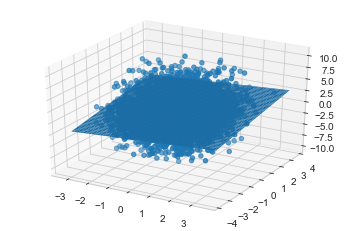

In [10]:
fig12 = plt.figure() # create the figure
ax = fig12.add_subplot(111,projection='3d') # create a 3d axis in the figure 
ax.scatter3D(x1,x2,y) # create scatterplot
ax.plot_surface(x1_values, x2_values, y_values); # create plane

We have plotted the randomly given data as a scatterplot.  
We had to use linspace of 100 values for $\hat{y}_i$, beacuase otherwise it would crash.

## **Question 3:** 
Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

### Answer to question 1.3:

In [11]:
#Defining the solver
beta_solve = (0,1,2)
def solve_OLS(beta_solve, y, x1, x2):
    # define objective function
    def obj(beta_solve):
        b0 = beta_solve[0] # defining each element in the tuble as variable so it looks cleaner in the return function.
        b1 = beta_solve[1]
        b2 = beta_solve[2]
        return np.sum((y - (b0 + b1*x1 + b2*x2))**2) # the funtion displayed above.

    result = optimize.minimize(obj,(0.5,0.5,0.5), method='nelder-mead') # solve the obj function
    return result

In [12]:
solved_beta = solve_OLS(beta_solve, y, x1, x2)
print(solved_beta.x)
# assigning values for later use.
solved_b0 = solved_beta.x[0]
solved_b1 = solved_beta.x[1]
solved_b2 = solved_beta.x[2]

[0.09565114 0.29293949 0.50329556]


By using the solver we find the followng values of $\beta$:  
$\hat{\beta}_0 = 0.096$  
$\hat{\beta}_1 = 0.29$  
$\hat{\beta}_2 = 0.50$

In [13]:
#Comparing the results with the matrix algebra
diff_beta = solved_beta.x - b
print(f"Difference between the two beta 0s = {diff_beta[0]:.6f}")
print(f"Difference between the two beta 1s = {diff_beta[1]:.6f}")
print(f"Difference between the two beta 2s = {diff_beta[2]:.6f}")

Difference between the two beta 0s = -0.000031
Difference between the two beta 1s = -0.000003
Difference between the two beta 2s = -0.000032


We see that in all 3 cases the beta found in the matrix algebra is a tiny bit larger than the one from the solver.

## **Question 4:** 
Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

### Answer to question 1.4

In [14]:
#defining the solver
def solve_LAD(b0, b1, b2, y = y, x1 = x1, x2 = x2):
    def LAD(b0, b1, b2): # defining the problem
        return np.sum(np.abs(y-(b0 + b1*x1 + b2*x2)))

    def obj(b): # defining the obj function to solve.
        return LAD(b[0],b[1],b[2])

    result = optimize.minimize(obj,(0.5,0.5,0.5), method='nelder-mead') # solve the obj function
    return result

In [15]:
solved_lad = solve_LAD(0,0,0)
solved_lad.x

array([0.09228812, 0.30748956, 0.51152848])

By using the least absolute deviation to estimate $\beta$, we get the following values:  
$\hat{\beta}_0 = 0.092$  
$\hat{\beta}_1 = 0.31$  
$\hat{\beta}_2 = 0.51$

In [16]:
#Comparing lad to the algebra ones.
diff_beta_matrix_lad = solved_lad.x - b
print(f"Difference between lad and algebra beta_0 = {diff_beta_matrix_lad[0]:.6f}")
print(f"Difference between lad and algebra beta_1 = {diff_beta_matrix_lad[1]:.6f}")
print(f"Difference between lad and algebra beta_2 = {diff_beta_matrix_lad[2]:.6f}")

Difference between lad and algebra beta_0 = -0.003394
Difference between lad and algebra beta_1 = 0.014547
Difference between lad and algebra beta_2 = 0.008201


In [17]:
#comparing lad to the ols
diff_beta_ols_lad = solved_lad.x - solved_beta.x
print(f"Difference between lad and ols beta_0 = {diff_beta_ols_lad[0]:.6f}")
print(f"Difference between lad and ols beta_1 = {diff_beta_ols_lad[1]:.6f}")
print(f"Difference between lad and ols beta_2 = {diff_beta_ols_lad[2]:.6f}")

Difference between lad and ols beta_0 = -0.003363
Difference between lad and ols beta_1 = 0.014550
Difference between lad and ols beta_2 = 0.008233


We find that the beta estimates from lad are longer away from the ones found by algebra and the ones found by ols. compared to the distance from the ols and algebra estimates.

We also tried to define a jacobian and hessian matrix and then use the Newton-CG to solve this problem, but ran into issues.
We didn't know whether to differentiate for x_1 and x_2 or beta_0, beta_1, and beta_2

In [18]:
#Defining symbols
x_1, x_2, y_1, b_0, b_1, b_2 = sm.symbols('x_1 x_2 y beta_0 beta_1 beta_2')

f = y_1 - (b_0 + b_1*x_1 + b_2*x_2) # maybe use abs here

In [19]:
# differentiating the function for the jacobian
Df = sm.Matrix([sm.diff(f,i) for i in [x_1,x_2]])
display(Df)
# differentiating the function for the hessian
Hf = sm.Matrix([[sm.diff(f,i,j) for j in [x_1,x_2]] for i in [x_1,x_2]])
display(Hf)

Matrix([
[-beta_1],
[-beta_2]])

Matrix([
[0, 0],
[0, 0]])

In [20]:
#Implementing the jacobian as a function
def LAD(b0, b1, b2, y = y, x1 = x1, x2 = x2): # defining the problem
    return np.sum(np.abs(y-(b0 + b1*x1 + b2*x2)))
def obj(b):
    return LAD(b[0],b[1],b[2])
def LAD_jac(b):
    return np.array(-b[1],-b[2])

In [21]:
obj(b)

12401.771781744184

In [22]:
#Solving with Newton-CG
b_guess = [0.01,0.5,0.5]
result = optimize.minimize(obj,b_guess,jac=LAD_jac, method='Newton-CG', options={'disp':True})

         Current function value: 12550.383368
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 6
         Hessian evaluations: 0


In [23]:
result.x # just returns guess, as the optimizer failed.

array([0.01, 0.5 , 0.5 ])

## **Question 5:**  
Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

### answer to question 1.5

In [24]:
N = 50
K = 5000
np.random.seed() # resetting seed

In [25]:
# generating empty lists.
sim_ols = []
sim_lad = []
for i in range(K): # appending the estimated beta from ols and lad. using list to make it easier to plot.
    x1,x2,y = DGP(N) # random x1,x2, and y for each K
    sim_ols.append(list(solve_OLS((0,0,0), y, x1, x2).x))
    sim_lad.append(list(solve_LAD(0,0,0, y, x1, x2).x))

In [26]:
# empty lists
sim_ols_b0 = []
sim_ols_b1 = []
sim_ols_b2 = []

#append the corresponding beta from the ols solver.
for i in range(K):
    sim_ols_b0.append(sim_ols[i][0])
    sim_ols_b1.append(sim_ols[i][1])
    sim_ols_b2.append(sim_ols[i][2])

#same for lad
# empty lists
sim_lad_b0 = []
sim_lad_b1 = []
sim_lad_b2 = []

#append the corresponding beta from the ols solver.
for i in range(K):
    sim_lad_b0.append(sim_lad[i][0])
    sim_lad_b1.append(sim_lad[i][1])
    sim_lad_b2.append(sim_lad[i][2])

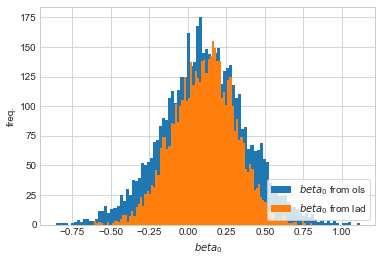

In [27]:
#making the histograms
fig15 = plt.figure()
ax = fig15.add_subplot(1,1,1)

ax.hist(sim_ols_b0,bins=100,label='$beta_0$ from ols')
ax.hist(sim_lad_b0,bins=100,label='$beta_0$ from lad')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$beta_0$')
ax.set_ylabel('freq.');

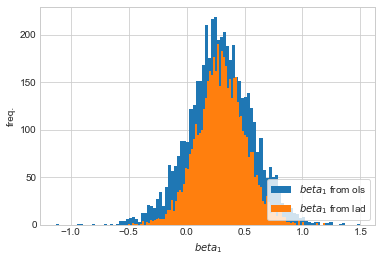

In [28]:
#making the histograms
fig15 = plt.figure()
ax = fig15.add_subplot(1,1,1)

ax.hist(sim_ols_b1,bins=100,label='$beta_1$ from ols')
ax.hist(sim_lad_b1,bins=100,label='$beta_1$ from lad')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$beta_1$')
ax.set_ylabel('freq.');

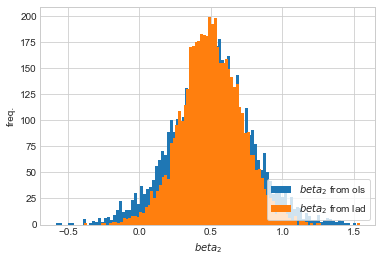

In [29]:
#making the histograms
fig15 = plt.figure()
ax = fig15.add_subplot(1,1,1)

ax.hist(sim_ols_b2,bins=100,label='$beta_2$ from ols')
ax.hist(sim_lad_b2,bins=100,label='$beta_2$ from lad')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$beta_2$')
ax.set_ylabel('freq.');

We have created 3 graphs, one for each beta simulation.  
It's clear from the graphs that the standard deviation of the beta estimation is lower when using least absolute deviations compared to using ordinary least squares.  
This is to be expected as the OLS estimation emphesises more on outliers in the observations than LAD.  
In this project we would prefer using the LAD, because the data is is a random normal distribution, so we assume that the actual true beta would most likely be closer to the mean, most of the estimations of beta from LAD is closer to the mean than the estimations from OLS, which is what we aim for.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [306]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [307]:
#defining utility from non-durable consumption
#def non_dur(c): # yup this is stupid
#    return c
# durable consumption
def v2(c, m2, d, chi, alpha, rho):
    return ((c**alpha * (d + chi * (m2 - c))**(1-alpha))**(1-rho))/(1-rho)



In [308]:
for i, m2 in enumerate(m2_vec):
    resulttest = optimize.minimize(obj2,0, method='nelder-mead', bounds=(0.0,m2))
    v2_vec_test.append(-resulttest.fun)
    c_vec_test[i] = resulttest.x
    x_vec_test[i] = m2 - resulttest.x

In [314]:
def solve_period_2(rho, alpha, chi):

    # vectors for the optimal values of v2, c and x
    v2_vec = np.empty(100)
    c_vec = np.empty(100)
    x_vec = np.empty(100)

    # solve for each m2 and d?
    for i, m2 in enumerate(m2_vec):
        # i. objective
        def obj(c):
            #return -v2(c, 2, 5, chi, alpha, rho)
            return -v2(c, m2, d_vec[i], chi, alpha, rho)
        def obj_2(c):
            return -v2(c, d_vec[i], m2, chi, alpha, rho)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,x0,method='L-BFGS-B',bounds=((1e-8,m2),))
        # iv. save
        v2_vec[i] = -result.fun
        c_vec[i] = result.x
        x_vec[i] = m2 - result.x
        
    return v2_vec, c_vec, x_vec

In [315]:
# solve
v2_vec, c_vec, x_vec =  solve_period_2(rho, alpha, chi)

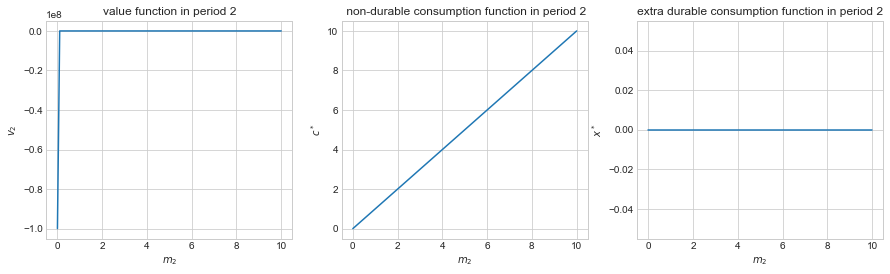

In [368]:
# illustration
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,3,1)
ax.plot(m2_vec,v2_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')

ax = fig.add_subplot(1,3,2)
ax.plot(m2_vec,c_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c^*$')
ax.set_title(' non-durable consumption function in period 2')

ax = fig.add_subplot(1,3,3)
ax.plot(m2_vec,x_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$x^*$')
ax.set_title('extra durable consumption function in period 2');

In [420]:
#3d graphs
# creating x grid for plotting
m2_values, d_values = np.meshgrid(m2_vec, d_vec) # meash for the 3d plots
v2_values = v2(c_vec, m2_values, d_values, chi, alpha, rho) # v2 values from function
c_values, not_needed = np.meshgrid(c_vec, m2_vec) # create c_values, doesn't matter wheter to use m2 or the d vec.
x_values, not_needed_again = np.meshgrid(x_vec, m2_vec) # create c_values

In [423]:
np.shape(x_values)

(100, 100)

In [424]:
x_values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

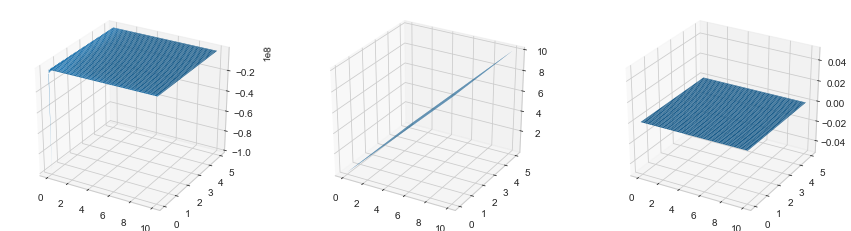

In [425]:
fig21 = plt.figure(figsize=(15,4)) # create the figure
ax = fig21.add_subplot(1,3,1,projection='3d') # create a 3d axis in the figure 
ax.plot_surface(m2_values, d_values, v2_values) # create plane for v2_values
ax = fig21.add_subplot(1,3,2,projection='3d')
ax.plot_surface(m2_values, d_values, c_values); # create plane for c_values
ax = fig21.add_subplot(1,3,3,projection='3d')
ax.plot_surface(m2_values, d_values, x_values); # create plane for x_values


**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [31]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

### testing shit

In [32]:
x_0, x_1 = sm.symbols('x_0 x_1') # defining symbols using x_0 and 1 for easier reading
x_list = [x_0,x_1] # defining list with the 2 x for use in the jacobian.
#Define ros as an equation so we can differentiate it in the jacobian
f_ros = (1.0-x_0)**2+2*(x_1-x_0**2)**2
 # differentiating the function for the jacobian
Df = sm.Matrix([sm.diff(f_ros,i) for i in x_list])
display(Df) # works fine # works fine :)

Matrix([
[-8*x_0*(-x_0**2 + x_1) + 2*x_0 - 2.0],
[                   -4*x_0**2 + 4*x_1]])

In [33]:
def jac2(x): # using the jacobian found by differentiating with sm
    return np.array([-8*x[0]*(-x[0]**2 + x[1]) + 2*x[0] - 2, -4*x[0]**2 + 4*x[1]])
x0 = np.array([2,1.1])
jac2(x0) # works fine

array([ 48.4, -11.6])

In [34]:
def jac(x,f): # jacobian by numerical differentiation.
        x_list1 = np.array([x[0] + Delta, x[1]])
        x_list2 = np.array([x[0], x[1] + Delta])
        jac = np.array([1/Delta * (f(x_list1) - f(x)), 1/Delta * (f(x_list2) - f(x))])
        return jac

In [35]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2
epsilon=1e-6
Theta=0.1
Delta=1e-8
max_iter=20
x0 = [2,2]
jac_rosen = jac(x0,rosen)

In [36]:
def func_theta(x): # step 6.1
    return rosen([x[0] - theta_fx1, x[1] - theta_fx2])

In [37]:
theta = Theta
theta_fx1 = theta * jac_rosen[0]
theta_fx2 = theta * jac_rosen[1]
f_theta = func_theta(x0)
n2 = 1
while f_theta < rosen(x0):
    print(f_theta)
    # step 6.2
    #print("iteration2: ", n2, "f_theta:", f_theta)
    #print("theta_fx", theta_fx1, theta_fx2)
    theta = theta/2
    if n2 == 10:
        break
    n2 += 1
    theta_fx1 = theta * jac_rosen[0]
    theta_fx2 = theta * jac_rosen[1]
    f_theta = func_theta(x0)

7.171199915171669


In [38]:
print(theta_fx1)
print(theta_fx2)
print(f_theta)

1.7000000074318677
-0.3999999975690116
11.162200029144557


In [39]:
print(jac_rosen)
print(jac2(x0)) # pretty freaking close mate

[34.00000015 -7.99999995]
[34 -8]


**Optimizer function:**

In [40]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000): # step 1 MAX ITER IS 20!!!!!!!! should be 10_000
    """ minimize function with gradient descent (stolen from Jeppe's slides)
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        epsilon (float): tolerance
        Theta (float): scale factor, not sure what Theta is used for yet, (maybe step size)
        Delta (float): for differentiation in the jacobi
        max_iter (int): maximum number of iterations
        
    Returns:
    
        x (np.ndarray): minimum
        n (int): number of iterations used
        
    """
    
    # step 2
    x = x0 # initial guess
    n = 1 # set n = 1
    fx = f(x0) # obj function with initial guess

    # step 3.1 compute jacobian
    def jac_func(x): # jacobian by numerical differentiation.
        x_list1 = np.array([x[0] + Delta, x[1]])
        x_list2 = np.array([x[0], x[1] + Delta])
        jac = np.array([1/Delta * (f(x_list1) - f(x)), 1/Delta * (f(x_list2) - f(x))])
        return jac
    
    def func_theta(x): # step 6.1
        #return f([x[0] - theta * jac[0], x[1] - theta * jac[1]])
        jac2 = jac_func(x)
        return f([x[0] - theta*jac2[0], x[1] - theta*jac2[1]])

    while n < max_iter:
        n2 = 1
        #print("x =",x)
        #print("iteration: ", n)
        #step 3.2
        jac = jac_func(x)
        #print("jac =",jac)

        # step 4
        if max(abs(jac)) < epsilon:
            break

        # step 5
        theta = Theta # step size
        # step 6.2
        #theta_fx1 = theta * jac[0]
        #theta_fx2 = theta * jac[1]
        f_theta = func_theta(x)

        #print("fx =", f(x))
        #print("f_theta =", f_theta)

        while f_theta > f(x):
            # step 6.2
            #print("iteration2: ", n2, "f_theta:", f_theta)
            #print("theta_fx", theta_fx1, theta_fx2)
            theta = theta/2
            if n2 == 10:
                break
            #theta_fx1 = theta * jac[0]
            #theta_fx2 = theta * jac[1]
            f_theta = func_theta(x)
            n2 += 1

        # step 9 update guess
        x = [x[0] - theta*jac[0], x[1] - theta*jac[1]]

        # step 10
        n += 1
        
    return x,n
    pass

**Test case:**

In [41]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 306 iterations
